<a href="https://colab.research.google.com/github/nik9hil/GAN/blob/master/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"nik9hil","key":"35c1d036d804f2a081421a652509832f"}'}

In [0]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d mrgravelord/complete-pokemon-image-dataset -p /content

complete-pokemon-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!mkdir train
!unzip complete-pokemon-image-dataset.zip -d train

mkdir: cannot create directory ‘train’: File exists
Archive:  complete-pokemon-image-dataset.zip
replace train/Abomasnow(Mega)/Abomasnow(Mega)_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as tvutils
import torch.utils.data as datautils
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# use gpu if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
# return iterable over dataset that will load minibatches (size = 128) for training
# preprocessing: images are resized to 64x64, each channel is normalized with mean = 0.5, s = 0.5
def get_loader(datapath):
    dataset = datasets.ImageFolder(root=datapath,transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    loader = datautils.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
    return loader

In [0]:
# view training data sample images as 8x8 grid
def view_images():
    sample = next(iter(dataloader))
    plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.title('Dataset Sample Images')
    #normalise the values of pixels
    plt.imshow(np.transpose(tvutils.make_grid(sample[0].to(device)[:72], padding=5, normalize=True).cpu(), (1,2,0)))

In [0]:
class Generator(nn.Module):
    def __init__(self, z_size=100, num_channels=3, gfm_size=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            # input layer (latent vector z taken as input)
            nn.ConvTranspose2d(z_size, gfm_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gfm_size * 8),
            nn.ReLU(True),
            
            # state size: (gfm_size * 8) x 4 x 4
            nn.ConvTranspose2d(gfm_size * 8, gfm_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gfm_size * 4),
            nn.ReLU(True),
            
            # state size: (gfm_size * 4) x 8 x 8
            nn.ConvTranspose2d( gfm_size * 4, gfm_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gfm_size * 2),
            nn.ReLU(True),
            
            # state size: (gfm_size * 2) x 16 x 16
            nn.ConvTranspose2d( gfm_size * 2, gfm_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gfm_size),
            nn.ReLU(True),
            
            # state size: (gfm_size) x 32 x 32
            nn.ConvTranspose2d(gfm_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # output: num_channels x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, num_channels=3, dfm_size=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            # input: num_channels x 64 x 64 
            nn.Conv2d(num_channels, dfm_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: dfm_size x 32 x 32
            nn.Conv2d(dfm_size, dfm_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dfm_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: (dfm_size * 2) x 16 x 16
            nn.Conv2d(dfm_size * 2, dfm_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dfm_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: (dfm_size * 4) x 8 x 8
            nn.Conv2d(dfm_size * 4, dfm_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dfm_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size: (dfm_size * 8) x 4 x 4
            nn.Conv2d(dfm_size * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        # view(-1) flattens the output from 2D to 1D 
        return self.main(input).view(-1)

In [0]:
# initialize all model weights
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

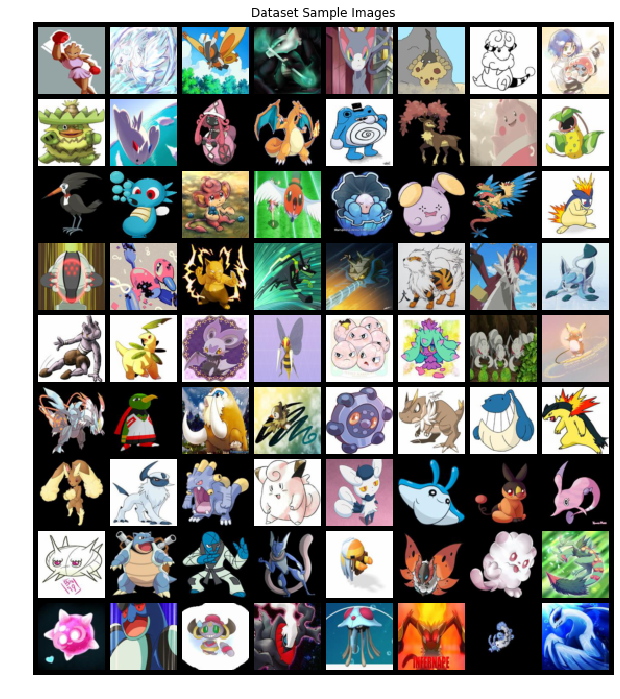

In [0]:
path = '/content/train/'
dataloader = get_loader(path)
view_images()

In [0]:
num_epochs = 400
z_size = 100
real_label = 1
fake_label = 0

# creating generator and discriminator networks
gen_net = Generator().to(device)
disc_net = Discriminator().to(device)

# init_weights is applied to self and every submodule recursively
gen_net.apply(init_weights)
disc_net.apply(init_weights)

print(gen_net, disc_net)

# create criterion to measure error (binary cross entropy between target and output)
#bce_loss = nn.BCELoss()

# create Adam SGD optimizers with learning rate 0.0002 and beta1 = 0.5
gen_opt = optim.Adam(gen_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_opt = optim.Adam(disc_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

# noise used for visualizing generator's learning curve 
test_noise = torch.randn(64, z_size, 1, 1, device=device)

image_lst = []
gen_losses = []
disc_losses = []
num_iter = 0

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
) 

In [0]:
for epoch in range(num_epochs):
    for idx,data in enumerate(dataloader):
          # DISCRIMINATOR UPDATE

          # set gradients of all model parameters to zero
        disc_net.zero_grad()
        
          # get batch of all real images
        real_batch = data[0].to(device)
        batch_size = real_batch.size(0)
          #labels = torch.full((batch_size,), real_label, device=device)
        
          # forward pass real batch through discriminator
        output_d = disc_net(real_batch)
        Dx_value = output_d.mean().item()
        #disc_loss_real = output - real_batch.view(-1)  #bce_loss(output, labels)
                
          # get batch of all fake images
        latent_z = torch.randn(batch_size, z_size, 1, 1, device=device)
        fake_batch = gen_net(latent_z)
            
          # classify fake images using discriminator
        output_g = disc_net(fake_batch.detach())
        disc_loss = -torch.mean(output_d)+torch.mean(output_g)
          # calculate gradients for discriminator in backward pass
        disc_loss.backward()
        DGz_value_1 = output_g.mean().item()
        
          # add gradients from both batches, save total loss
        disc_losses.append(disc_loss.item())
        
          # update discriminator
        disc_opt.step()
        
        for p in disc_net.parameters():
          p.data.clamp_(-0.01,0.01)
        
        if epoch%5 == 0:
          # GENERATOR UPDATE
        # set gradients of all model parameters to zero
          gen_net.zero_grad()
        
        # after updating discriminator, perform another forward pass of fake batch
          output = disc_net(fake_batch)
        
        # calculate and save generator loss on discriminator's new output 
          gen_loss = -torch.mean(output)
          gen_losses.append(gen_loss.item())
        
        # calculate gradients for generator in backward pass
          gen_loss.backward()
          DGz_value_2 = output.mean().item()
        
        # update generator
          gen_opt.step()
        
        # print update every 100th batch
          if idx % 100 == 0:
              print('Epoch: %d/%d Idx: %d/%d\nLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, idx, len(dataloader),
                  disc_loss.item(), gen_loss.item(), Dx_value, DGz_value_1, DGz_value_2))
        
        # periodically test and save generator performance on test_noise
        # do not calculate gradients
          if (num_iter % 500 == 0) or ((epoch == num_epochs-1) and (idx == len(dataloader)-1)):           
              with torch.no_grad():
                  fake_image = gen_net(test_noise).detach().cpu()
              image_lst.append(tvutils.make_grid(fake_image, padding=2, normalize=True))
        
          num_iter += 1

Epoch: 0/400 Idx: 0/193
Loss_D: 0.0085	Loss_G: 0.0053	D(x): -0.6856	D(G(z)): -0.6771 / -0.0053
Epoch: 0/400 Idx: 100/193
Loss_D: -0.0487	Loss_G: 0.0261	D(x): 0.0419	D(G(z)): -0.0068 / -0.0261
Epoch: 5/400 Idx: 0/193
Loss_D: -1.5240	Loss_G: 0.7354	D(x): 0.7882	D(G(z)): -0.7358 / -0.7354
Epoch: 5/400 Idx: 100/193
Loss_D: -0.3271	Loss_G: 0.2293	D(x): 0.0296	D(G(z)): -0.2975 / -0.2293
Epoch: 10/400 Idx: 0/193
Loss_D: -1.5170	Loss_G: 0.7319	D(x): 0.7854	D(G(z)): -0.7316 / -0.7319
Epoch: 10/400 Idx: 100/193
Loss_D: -0.4909	Loss_G: 0.5119	D(x): 0.3157	D(G(z)): -0.1752 / -0.5119
Epoch: 15/400 Idx: 0/193
Loss_D: -1.5277	Loss_G: 0.7354	D(x): 0.7925	D(G(z)): -0.7352 / -0.7354
Epoch: 15/400 Idx: 100/193
Loss_D: -0.8908	Loss_G: 0.5272	D(x): 0.4569	D(G(z)): -0.4339 / -0.5272
Epoch: 20/400 Idx: 0/193
Loss_D: -1.5224	Loss_G: 0.7315	D(x): 0.7909	D(G(z)): -0.7315 / -0.7315
Epoch: 20/400 Idx: 100/193
Loss_D: -0.2009	Loss_G: 0.1162	D(x): 0.6063	D(G(z)): 0.4054 / -0.1162
Epoch: 25/400 Idx: 0/193
Loss_D: -1

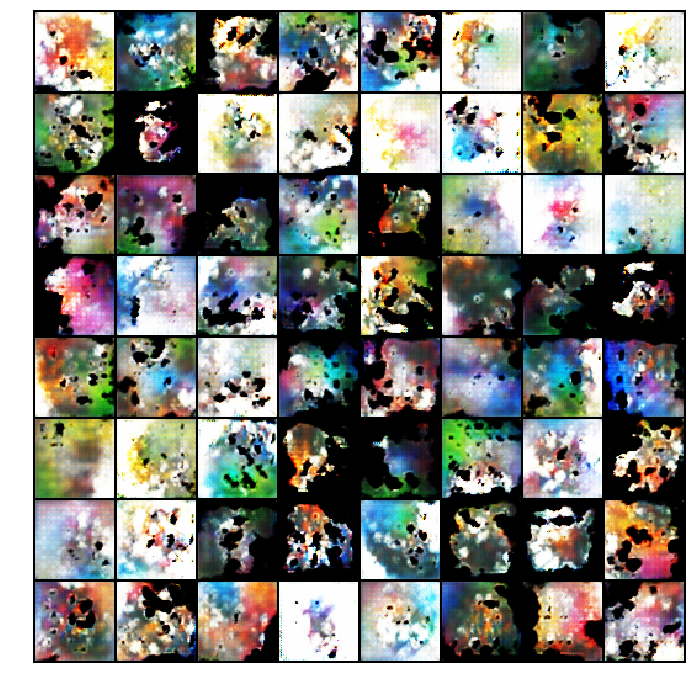

In [0]:
# generate 12x12" figure, axes off, showing progression of generated images
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in image_lst]

In [0]:
import pickle 
pickle.dump(gen_net,('generator','wb'))
pickle.dump(disc_net, ('discriminator',''))

RuntimeError: ignored

In [0]:
#import os
#os.getcwd()
torch.save(gen_net.state_dict(),'./content')

In [0]:
torch.save(disc_net.state_dict(),'./content')

In [0]:
new_gen = Generator().to(device)
new_gen.load_state_dict(torch.load('./content'))

<All keys matched successfully>

In [0]:
new_gen.state_dict()

OrderedDict([('main.0.weight',
              tensor([[[[-3.6906e-02, -2.2973e-02, -3.5397e-02,  1.8219e-02],
                        [-3.6947e-03,  3.3899e-02,  4.6837e-03, -3.9300e-02],
                        [ 7.4179e-03, -5.1415e-02, -8.3769e-03, -3.6010e-02],
                        [-3.0823e-03, -2.4024e-02, -6.1871e-02, -7.7167e-02]],
              
                       [[ 3.3470e-02, -2.2809e-03,  5.4560e-03, -3.6413e-03],
                        [ 5.0298e-02,  9.5051e-04,  2.9293e-02,  1.8830e-02],
                        [ 6.1012e-02,  3.9756e-02,  2.2117e-02,  3.0054e-02],
                        [ 4.5065e-02,  3.1676e-02,  2.1711e-02,  5.6018e-02]],
              
                       [[ 4.1442e-03, -1.8627e-02, -7.0127e-02, -2.8271e-02],
                        [ 1.2528e-02,  2.5472e-02,  1.8835e-02, -2.7798e-02],
                        [ 1.5854e-03, -1.2593e-02,  1.8701e-02,  3.1800e-02],
                        [-3.8085e-03, -1.8843e-02, -1.9207e-02,  7.8616e-03]],
